In [1]:
# Estimating the Dynamical Mass of a Galaxy Cluster
# Project: Estimating the Dynamical and Luminous Mass of a Galaxy Cluster using SDSS Data
# 1. First we have to import python libraries commonly used in data analysis and visualization:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from astropy import constants as const
from astropy import units as u

In [24]:
# 2. Load and Clean the Data and Remove duplicate entries (same objid with multiple measurements)
# Load CSV file from SDSS SQL query export
print("Loading data...")
data = pd.read_csv('Skyserver_SQL6_30_2025 7_00_45 AM.csv', comment='#')
data = data.drop_duplicates(subset='objid', keep='first')  # For remove duplicates

Loading data...


In [25]:
# 3. We have to Calculate Velocities from Redshift

c = 3e5  # Approx. speed of light in km/s
print("Calculating galaxy velocities...")
data['velocity'] = data['specz'] * c

mean_z = data['specz'].mean()
mean_velocity = mean_z * c
velocity_dispersion = data['velocity'].std()

print(f"\nMean redshift (z): {mean_z:.4f}")
print(f"Mean radial velocity: {mean_velocity:.2f} km/s")
print(f"Velocity dispersion: {velocity_dispersion:.2f} km/s")

Calculating galaxy velocities...

Mean redshift (z): 0.0808
Mean radial velocity: 24250.00 km/s
Velocity dispersion: 2572.77 km/s


In [26]:
# 4. We have to Select Cluster Members (within ±3σ of mean velocity)

print("\nFiltering cluster members...")
lower_bound = mean_velocity - 3 * velocity_dispersion
upper_bound = mean_velocity + 3 * velocity_dispersion

cluster_members = data[(data['velocity'] >= lower_bound) & 
                       (data['velocity'] <= upper_bound)]

print(f"Total galaxies in dataset: {len(data)}")
print(f"Cluster members within ±3σ: {len(cluster_members)}")
print(f"Cluster velocity dispersion: {cluster_members['velocity'].std():.2f} km/s")


Filtering cluster members...
Total galaxies in dataset: 92
Cluster members within ±3σ: 91
Cluster velocity dispersion: 1317.10 km/s


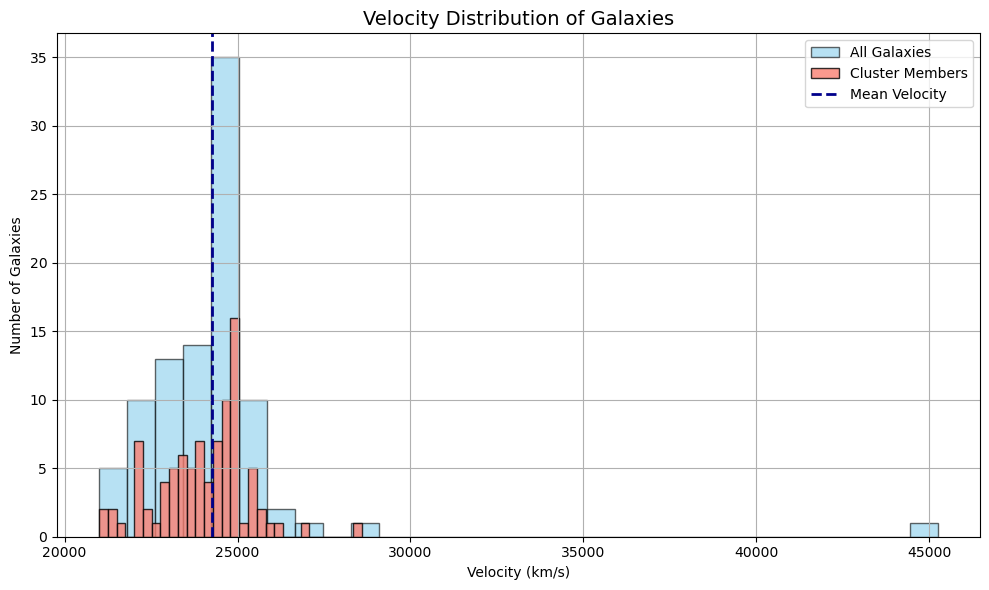

In [27]:
# 5. Velocity Histogram (Colorful & Styled)

plt.figure(figsize=(10, 6))
plt.hist(data['velocity'], bins=30, alpha=0.6, label='All Galaxies', color='skyblue', edgecolor='black')
plt.hist(cluster_members['velocity'], bins=30, alpha=0.8, label='Cluster Members', color='salmon', edgecolor='black')
plt.axvline(mean_velocity, color='darkblue', linestyle='--', linewidth=2, label='Mean Velocity')
plt.title('Velocity Distribution of Galaxies', fontsize=14)
plt.xlabel('Velocity (km/s)')
plt.ylabel('Number of Galaxies')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

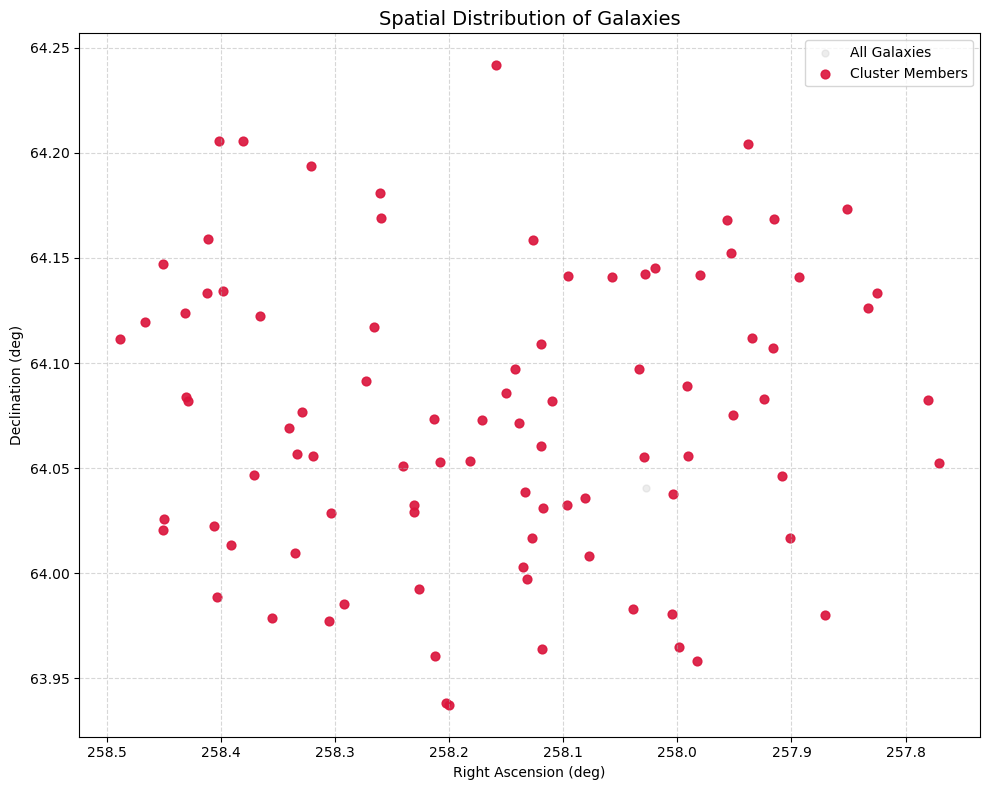

In [28]:
# 6. Spatial Distribution (RA vs Dec)

plt.figure(figsize=(10, 8))
plt.scatter(data['ra'], data['dec'], alpha=0.4, label='All Galaxies', s=25, color='lightgray')
plt.scatter(cluster_members['ra'], cluster_members['dec'], alpha=0.9, label='Cluster Members', s=40, color='crimson')
plt.xlabel('Right Ascension (deg)')
plt.ylabel('Declination (deg)')
plt.title('Spatial Distribution of Galaxies', fontsize=14)
plt.legend()
plt.gca().invert_xaxis()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Calculating angular separation from cluster center...


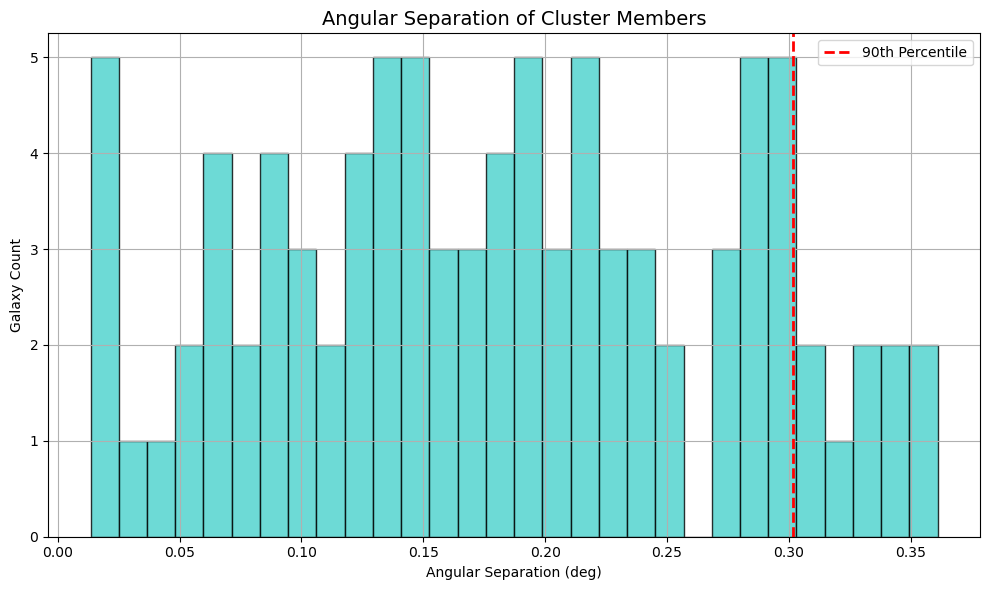

In [29]:
# 7. Angular Separation Calculation & Histogram

center_ra, center_dec = 258.1294, 64.0926
print("Calculating angular separation from cluster center...")
cluster_members = cluster_members.copy()

# Calculate angular separation using .loc for assignment
cluster_members.loc[:, 'angular_sep'] = np.sqrt(
    (cluster_members['ra'] - center_ra)**2 + 
    (cluster_members['dec'] - center_dec)**2)

# Plot angular separation histogram
plt.figure(figsize=(10, 6))
plt.hist(cluster_members['angular_sep'], bins=30, alpha=0.8, color='mediumturquoise', edgecolor='black')
plt.axvline(cluster_members['angular_sep'].quantile(0.9), color='red', linestyle='--', linewidth=2, 
         label='90th Percentile')
plt.title('Angular Separation of Cluster Members', fontsize=14)
plt.xlabel('Angular Separation (deg)') 
plt.ylabel('Galaxy Count')
plt.legend()  
plt.grid(True)  
plt.tight_layout()
plt.show()


In [30]:
# 8. To calculate the Mass Estimation 


from astropy.cosmology import FlatLambdaCDM
from astropy import constants as const
from astropy import units as u

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
angular_scale = cosmo.kpc_proper_per_arcmin(mean_z).to('Mpc/deg') / 60

cluster_members = cluster_members.copy()  # Create explicit copy first
cluster_members['proj_sep_mpc'] = cluster_members['angular_sep'] * angular_scale.value


# Estimate cluster radius (90th percentile)
cluster_radius = cluster_members['proj_sep_mpc'].quantile(0.9)

# Dynamical mass using virial theorem
G = const.G.to('km^2 Mpc M_sun^-1 s^-2').value
velocity_disp = cluster_members['velocity'].std()
dynamical_mass = (3 * np.pi * velocity_disp**2 * cluster_radius * u.Mpc.to('km')) / (2 * G)

# Luminous mass estimation (g-band)
sun_gmag = 5.12
lum_dist = cosmo.luminosity_distance(mean_z).value * 1e6  # in pc
cluster_members = cluster_members.copy()  
cluster_members.loc[:, 'abs_gmag'] = cluster_members['gmag'] - 5 * np.log10(lum_dist / 10)
cluster_members.loc[:, 'L_g'] = 10**(0.4 * (sun_gmag - cluster_members['abs_gmag']))
luminous_mass = (cluster_members['L_g'] * 100).sum()

# Mass ratio
dynamical_mass_ratio = dynamical_mass / luminous_mass

print(f"\nEstimated Cluster Radius: {cluster_radius:.2f} Mpc")
print(f"Dynamical Mass: {dynamical_mass/1e14:.2f} × 10^14 M_sun")
print(f"Luminous Mass: {luminous_mass/1e14:.2f} × 10^14 M_sun")
print(f"Mass Ratio (Dyn/Lum): {dynamical_mass_ratio:.2f}")

# ************************The END*******************************


Estimated Cluster Radius: 0.03 Mpc
Dynamical Mass: 16189698413208446976.00 × 10^14 M_sun
Luminous Mass: 1.52 × 10^14 M_sun
Mass Ratio (Dyn/Lum): 10652722521167308800.00
